In [1]:
from __future__ import print_function

import numpy as np
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

working_path = "../outs/"

K.set_image_dim_ordering('th')  # Theano dimension ordering in this code

img_rows = 512
img_cols = 512

smooth = 1.


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_np(y_true,y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def get_unet():
    inputs = Input((1,img_rows, img_cols))
    conv1 = Convolution2D(32, 3, 3, activation="relu", border_mode="same")(inputs)
    conv1 = Convolution2D(32, 3, 3, activation="relu", border_mode="same")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation="relu", border_mode="same")(pool1)
    conv2 = Convolution2D(64, 3, 3, activation="relu", border_mode="same")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=1.0e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model


def train_and_predict(use_existing):
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    imgs_train = np.load(working_path+"fake_trainImages.npy").astype(np.float32)
    imgs_mask_train = np.load(working_path+"fake_trainMasks.npy").astype(np.float32)

    imgs_test = np.load(working_path+"fake_testImages.npy").astype(np.float32)
    imgs_mask_test_true = np.load(working_path+"fake_testMasks.npy").astype(np.float32)
    
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean  # images should already be standardized, but just in case
    imgs_train /= std

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    # Saving weights to unet.hdf5 at checkpoints
    model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss', save_best_only=True)
    #
    # Should we load existing weights? 
    # Set argument for call to train_and_predict to true at end of script
    if use_existing:
        model.load_weights('./unet.hdf5')
        
    # 
    # The final results for this tutorial were produced using a multi-GPU
    # machine using TitanX's.
    # For a home GPU computation benchmark, on my home set up with a GTX970 
    # I was able to run 20 epochs with a training set size of 320 and 
    # batch size of 2 in about an hour. I started getting reseasonable masks 
    # after about 3 hours of training. 
    #
    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    model.fit(imgs_train, imgs_mask_train, batch_size=10, nb_epoch=20, verbose=1, shuffle=True,
              callbacks=[model_checkpoint])

    # loading best weights from training session
    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model.load_weights('./unet.hdf5')

    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
    num_test = len(imgs_test)
    imgs_mask_test = np.ndarray([num_test,1,512,512],dtype=np.float32)
    for i in range(num_test):
        imgs_mask_test[i] = model.predict([imgs_test[i:i+1]], verbose=0)[0]
    np.save('masksTestPredicted.npy', imgs_mask_test)
    mean = 0.0
    for i in range(num_test):
        mean+=dice_coef_np(imgs_mask_test_true[i,0], imgs_mask_test[i,0])
    mean/=num_test
    print("Mean Dice Coeff : ",mean)

/home/lucas/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3138406260572112941
]


In [3]:
import matplotlib.pyplot as plt

def make_blob_mask(width, height, x, y, s, t):
    xx = np.arange(width)
    yy = np.arange(height)
    xxx, yyy = np.meshgrid(xx, yy)
    
    z = np.exp(-0.5*((xxx-x)**2 + (yyy-y)**2)/(s**2))
    
    m = (z>t)
    
    return z, m
    
    

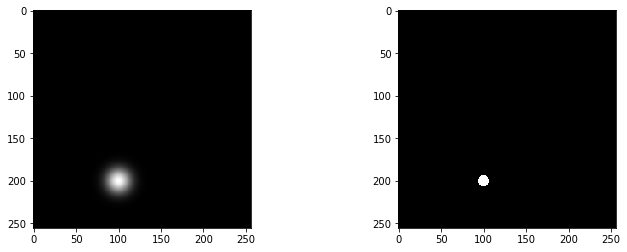

(256, 256)

In [4]:
img_test, img_mask = make_blob_mask(256,256,100,200,10, 0.8)

fig,ax = plt.subplots(1,2,figsize=[12,4])
ax[0].imshow(img_test,cmap='gray')        
ax[1].imshow(img_mask,cmap='gray')
            
plt.show()
img_test.shape

In [5]:
import random

num_images = 100


final_images = np.ndarray([num_images,1,512,512],dtype=np.float32)
final_masks = np.ndarray([num_images,1,512,512],dtype=np.float32)

for i in range(num_images):
    img_test, img_mask = make_blob_mask(512,512,random.randrange(10,502),random.randrange(10,502),10, 0.8)
    
    final_images[i,0] = img_test
    final_masks[i,0] = img_mask
    

final_images.shape


rand_i = np.random.choice(range(num_images),size=num_images,replace=False)
test_i = int(0.2*num_images)
np.save(working_path+"fake_trainImages.npy",final_images[rand_i[test_i:]])
np.save(working_path+"fake_trainMasks.npy",final_masks[rand_i[test_i:]])
np.save(working_path+"fake_testImages.npy",final_images[rand_i[:test_i]])
np.save(working_path+"fake_testMasks.npy",final_masks[rand_i[:test_i]])

    
    

In [6]:
if __name__ == '__main__':
    train_and_predict(False)

------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------


/home/lucas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
/home/lucas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
/home/lucas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/home/lucas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/home/lucas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
/home/lucas/anaconda3/lib/python3.6/site-pac

------------------------------
Fitting model...
------------------------------
Epoch 1/20


KeyboardInterrupt: 